# Quickstart
This notebook will help you get started with ChromStream quickly. It covers setting up an experiment, adding chromatograms to it, plotting and integrating.

## Setting up and parsing

ChromStream uses a 3-tier system for accessing data:
- Experiment: Contains all data, including e.g. log files
- Channel: Contains the chromatograms of a given detector/channel
- Chromatogram: Contains raw data and metadata of an individual chromatogram

Chromatograms can be parsed individually, or directly added to an experiment.
To get started, let's parse a single chromatogram from the testing data included in this repo.

In [17]:
import chromstream as cs
from pathlib import Path

testdata = Path("../..") / "dev_data" / "chroms" /  "pyGCMS_calibration" / "calibration_20250114_no1"
chrom_list = sorted(testdata.iterdir())

chrom = cs.parse_chromatogram_txt(chrom_list[0])

From the chromatogram object we can access all important information as properties of the chromatogram class.
The data is given as a pd.DataFrame(), the metadata is a dict. Certain properties from the metadata can be accessed directly, such as the injection time (as pd.DateTime object) or the channel:

In [18]:
# data
print(chrom.data.head())
# metadata
print(chrom.metadata.keys())
# Channel
print('Channel:', chrom.channel)
# Injection time
print('Injection time:', chrom.injection_time)
# Unit
print('Signal Unit:', chrom.signal_unit)

   Time (min)  Value (pA)
0    0.000667    7.365880
1    0.001333    7.364733
2    0.002000    7.364567
3    0.002667    7.364584
4    0.003333    7.364558
dict_keys(['\ufeffURL', 'Channel', 'Data Vault', 'Sequence', 'Number', 'Position', 'Processing Method', 'Instrument Method', 'Type', 'Status', 'Inject Time', 'Volume (µl)', 'Dilution Factor', 'Weight', 'Time Min. (min)', 'Time Max. (min)', 'Data Points', 'Detector', 'Generating Data System', 'Exporting Data System', 'Operator', 'Signal Unit', 'Signal Min.', 'Signal Max.', 'Driver Name', 'Channel Type', 'Min. Step (s)', 'Max. Step (s)', 'Average Step (s)', 'time_unit'])
Channel: FID_right
Injection time: 2025-01-14 18:13:58
Signal Unit: pA


When doing on-line GC, you will have more than one chromatogram, potentially also from multiple channels.

Therefore, we first set up an 'Experiment' object, to which we will add our chromatograms. Chromatograms can be added using the 'add_chromatogram' method. We can add the chromatogram directly from the path, or parse it first.
The method automatically infers the channel of the chromatogram, although you can override this. Notice how calling 'Exp.channel_names' gives the list of channels.

In [19]:
Exp = cs.Experiment(name="Quickstart Example")
Exp.add_chromatogram(chrom_list[0])
# or alternatively:
# Exp.add_chromatogram(chrom) 
# when you parsed the chromatogram beforehand

print(Exp.channel_names)

['FID_right']


Let's add all chromatograms for the calibration run to the experiment. We now have two different channels in the experiment:

In [20]:
Exp_full = cs.Experiment(name="Quickstart Example 2")
for chrom_path in chrom_list:
    Exp_full.add_chromatogram(chrom_path)

print(Exp_full.channel_names)  # summary of the experiment

['FID_right', 'TCD']


Channels can be accessed using the .channels method with their name.
From there, you can access chromatograms by index:

In [21]:
Exp_full.channels['FID_right'].chromatograms[0].data.head()

,Time (min),Value (pA)
0,0.000667,7.365880
1,0.001333,7.364733
2,0.002000,7.364567
3,0.002667,7.364584
4,0.003333,7.364558


This way you have access to all chromatograms with just one line.

## Plotting
The first thing you generally want to do is look at your chromatograms.
This can be done at all levels, from experiment to single chromatogram. Note that the experiment uses 'plot_chromatograms' instead of 'plot'.
Hint: To make the plots interactive, add 
```python
%matplotlib widget
```
to the cell.

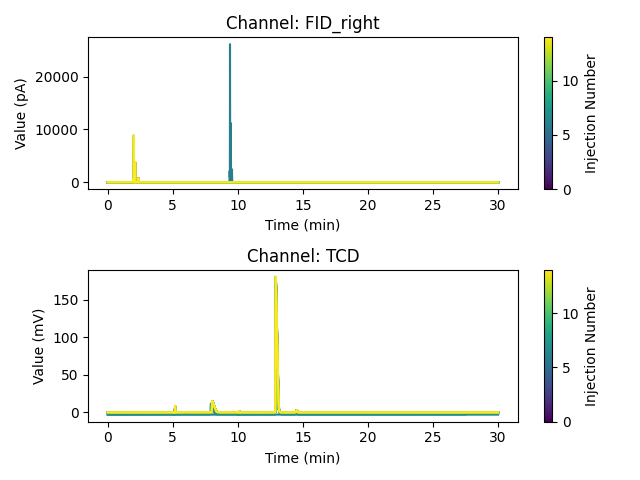

In [22]:
# Experiment:
%matplotlib widget
Exp_full.plot_chromatograms()

<Axes: title={'center': 'Channel: FID_right'}, xlabel='Time (min)', ylabel='Value (pA)'>

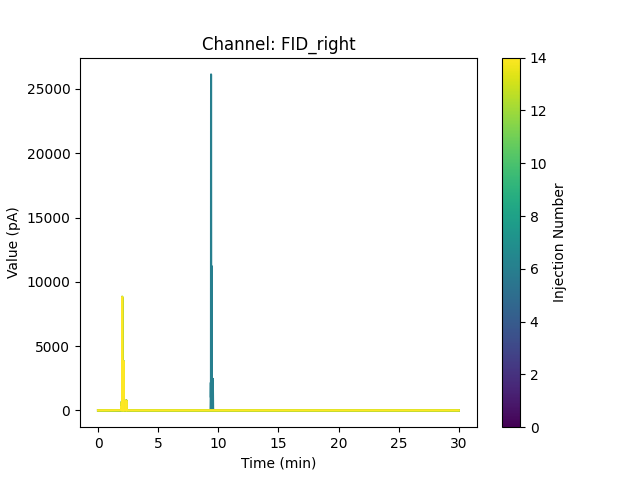

In [23]:
# Channel:
Exp_full.channels['FID_right'].plot()

<Axes: title={'center': 'Chromatogram - FID_right - ../../dev_data/chroms/pyGCMS_calibration/calibration_20250114_no1/10_FID_right.txt'}, xlabel='Time (min)', ylabel='Value (pA)'>

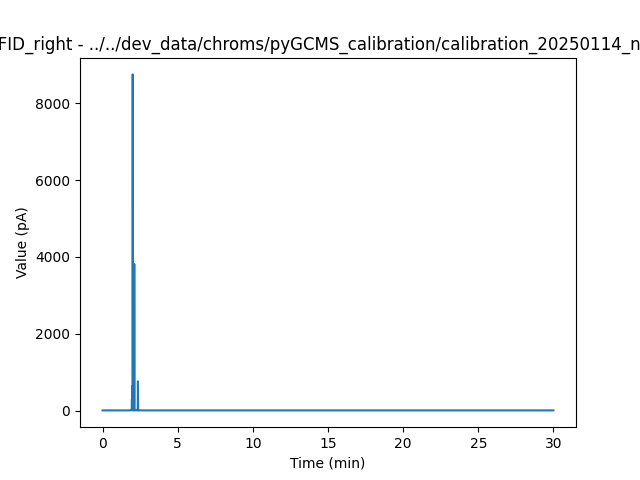

In [24]:
# Chromatogram:
Exp_full.channels['FID_right'].chromatograms[0].plot()

## Baseline subtraction
The baselines of chromatograms can vary a lot. Therefore, ChromStream allows you to use custom baseline functions.

In [25]:
print(cs.list_baseline_functions())

min_subtract
time_window_baseline
time_point_baseline
linear_baseline


To showcase how adding a custom baseline works, we are going to reproduce the min_subtract function.
The function needs to take as input the dataframe of the chromatogram, and return the baseline-corrected signal.
The apply_baseline method will add a new column to the chromatogram.data df. If you instead want to overwrite the existing data, use 'inplace=True'. This feature is turned off by default.

In [26]:
import pandas as pd

def min_subtract2(data: pd.DataFrame) -> pd.Series:
    signal = data[data.columns[1]]
    return signal - signal.min()

chrom2 = Exp_full.channels['FID_right'].chromatograms[3]
chrom2.apply_baseline(min_subtract2)

# To overwrite the data, use:
# chrom2.apply_baseline(min_subtract2, inplace=True)

chrom2.data.head()

,Time (min),Value (pA),Value (pA)_BLcorr
0,0.000667,7.372743,0.020986
1,0.001333,7.367826,0.016069
2,0.002000,7.368490,0.016733
3,0.002667,7.368260,0.016503
4,0.003333,7.368131,0.016374


A couple simple baseline functions are included in the package. You can print the documention of each one using the ```.__doc__``` method.

In [51]:
print('Availible baselines:\n',
      cs.list_baseline_functions())

print('\nExample:'
        '\nLinear baseline: ',
        cs.linear_baseline.__doc__)

Availible baselines:
 min_subtract
time_window_baseline
time_point_baseline
linear_baseline

Example:
Linear baseline:  
    Subtract a linear baseline defined by two time points.
    Determines a linear baseline between the signal values at the two specified time points.

    Args:
        data: DataFrame containing time and signal columns
        start_time: Time point to define the start of the baseline. Use the same unit as the chromatogram.
        end_time: Time point to define the end of the baseline. Use the same unit as the chromatogram.

    Returns:
        Corrected signal as pandas Series
    


This means we can just import the function from the package, and check whether it is good enough. Note that in this example the baseline is very flat and the signal very strong.

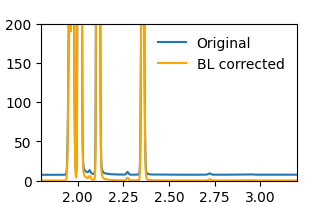

In [28]:
import matplotlib.pyplot as plt
%matplotlib widget
from chromstream.data_processing import min_subtract

chrom2.apply_baseline(min_subtract)
fig, ax = plt.subplots(figsize=(3.3, 3.3/1.618))
chrom2.plot(ax=ax)
chrom2.plot(column='Value (pA)_BLcorr', ax=ax, color='orange')
ax.set_title('')
ax.set_ylim(0, 200)
ax.set_xlim(1.8, 3.2)
ax.legend(['Original', 'BL corrected'], frameon=False)
plt.show()

## Integration
In the current implementation, peaks are integrated in specified boundaries. Good separation is therefore critical if you want to isolate specific compounds.
You can integrate both a single chromatogram, as well as a full channel, using the .integrate_peaks() method and a peaklist provided as a dict:
To make things easier, we use the baseline subtraction with the overwrite set to True.
For a single chromatogram, the integration gives a dictionary with the timestamp of the injection:

In [29]:
Peaks = {'Methane_Ethane':[1.93,1.99], 'Propane':[1.99,2.04], 'Butane': [2.085,2.16], 'Pentane':[2.325,2.385]}
integral_list = []
chrom2.apply_baseline(min_subtract, inplace=True)
integrals_single = chrom2.integrate_peaks(Peaks)
#printing results:
print(integrals_single)
# showing as dataframe:
pd.DataFrame([integrals_single])

{'Timestamp': Timestamp('2025-01-14 19:45:09'), 'Methane_Ethane': np.float64(11.70935060763651), 'Propane': np.float64(103.54438043609807), 'Butane': np.float64(46.19299856635804), 'Pentane': np.float64(10.331378662427008)}


,Timestamp,Methane_Ethane,Propane,Butane,Pentane
0,2025-01-14 19:45:09,11.709351,103.54438,46.192999,10.331379


When integrating a channel, we apply the baseline to the whole dataset first, then integrate:

In [30]:
Exp_full.channels['FID_right'].apply_baseline(min_subtract, inplace=True)
integrals_full = Exp_full.channels['FID_right'].integrate_peaks(Peaks)
integrals_full.sort_values('Timestamp').reset_index(drop=True)

,Timestamp,Methane_Ethane,Propane,Butane,Pentane
0,2025-01-14 13:41:40,0.002406,0.002037,0.003068,0.002265
1,2025-01-14 14:09:55,10.752795,94.976175,42.308592,9.436128
2,2025-01-14 14:41:08,11.805789,104.235329,46.425401,10.362865
3,2025-01-14 15:11:33,11.915303,105.252292,46.925896,10.486735
4,2025-01-14 15:41:56,11.920735,105.291477,46.955402,10.498406
5,2025-01-14 16:12:20,11.915414,105.249754,46.937924,10.496388
6,2025-01-14 16:42:44,11.929328,105.329486,46.968685,10.503923
7,2025-01-14 17:13:09,11.868515,104.824002,46.752611,10.455457
8,2025-01-14 17:43:33,11.841344,104.603074,46.648921,10.434957
9,2025-01-14 18:13:58,11.764285,103.999964,46.393107,10.375813


## Full processing
Putting everything shown above together, we can do a full processing of our data in just 9 lines:

In [31]:
testdata = Path("../..") / "dev_data" / "chroms" /  "pyGCMS_calibration" / "calibration_20250114_no1" # data location
chrom_list = testdata.iterdir() #list of chromatograms

Exp_full = cs.Experiment(name="Quickstart Example 2") # create experiment
for chrom_path in chrom_list: 
    Exp_full.add_chromatogram(chrom_path) # adding each chromatograms to the experiment

Peaks = {'Methane_Ethane':[1.93,1.99], 'Propane':[1.99,2.04], 'Butane': [2.085,2.16], 'Pentane':[2.325,2.385]} # setting the peak boundaries

Exp_full.channels['FID_right'].apply_baseline(min_subtract, inplace=True) # applying a baseline
integrals_full = Exp_full.channels['FID_right'].integrate_peaks(Peaks) # integrating peaks
integrals_full.sort_values('Timestamp').reset_index(drop=True) # sorting and showing the integration results

,Timestamp,Methane_Ethane,Propane,Butane,Pentane
0,2025-01-14 13:41:40,0.002406,0.002037,0.003068,0.002265
1,2025-01-14 14:09:55,10.752795,94.976175,42.308592,9.436128
2,2025-01-14 14:41:08,11.805789,104.235329,46.425401,10.362865
3,2025-01-14 15:11:33,11.915303,105.252292,46.925896,10.486735
4,2025-01-14 15:41:56,11.920735,105.291477,46.955402,10.498406
5,2025-01-14 16:12:20,11.915414,105.249754,46.937924,10.496388
6,2025-01-14 16:42:44,11.929328,105.329486,46.968685,10.503923
7,2025-01-14 17:13:09,11.868515,104.824002,46.752611,10.455457
8,2025-01-14 17:43:33,11.841344,104.603074,46.648921,10.434957
9,2025-01-14 18:13:58,11.764285,103.999964,46.393107,10.375813
